In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


<h1>1. Import Library</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
from plotly.subplots import make_subplots

<h1>2. Prepare Data</h1>

In [3]:
url = '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(url)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Loại bỏ cột không cần thiết
if 'customerID' in data.columns:
    data.drop('customerID', axis=1, inplace=True)

In [6]:
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

*  Khi đi sâu vào dữ liệu, chúng ta nhận thấy rằng **`TotalCharges`** có những khoảng giá trị trắng, thay vì giá trị số hoặc `NaN`.  
Điều này có thể xảy ra do lỗi nhập liệu hoặc khoảng trắng bị ghi nhận thay vì giá trị thực.


In [7]:
data[data['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [8]:
data.drop(labels=data[data['tenure'] == 0]. index, axis=0, inplace=True)
data[data['tenure'] == 0].index

Index([], dtype='int64')

In [9]:
data.fillna(data["TotalCharges"].mean())

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [10]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
data["SeniorCitizen"]= data["SeniorCitizen"].map({0: "No", 1: "Yes"})
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=data['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=data['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [13]:
print(data.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [14]:
fig = px.histogram(data, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [15]:
labels = data['PaymentMethod'].unique()
values = data['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [16]:
fig = px.histogram(data, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [17]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

In [18]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [19]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [20]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(data, x="Churn", color="SeniorCitizen", title="<b>Chrun distribution w.r.t. Senior Citizen</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [21]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [22]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="Churn", color="PaperlessBilling",  title="<b>Chrun distribution w.r.t. Paperless Billing</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [23]:
fig = px.histogram(data, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [24]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(data, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

<ipython-input-25-445dcfde850f>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

<ipython-input-25-445dcfde850f>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



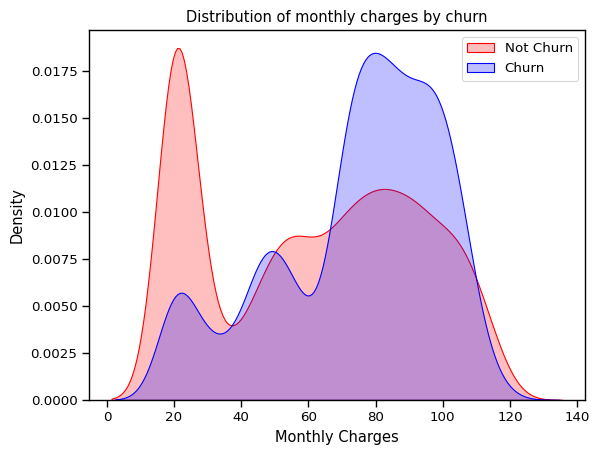

In [25]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'No') ],
                color="Red", shade = True);
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

<ipython-input-26-08b2dccb725d>:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

<ipython-input-26-08b2dccb725d>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



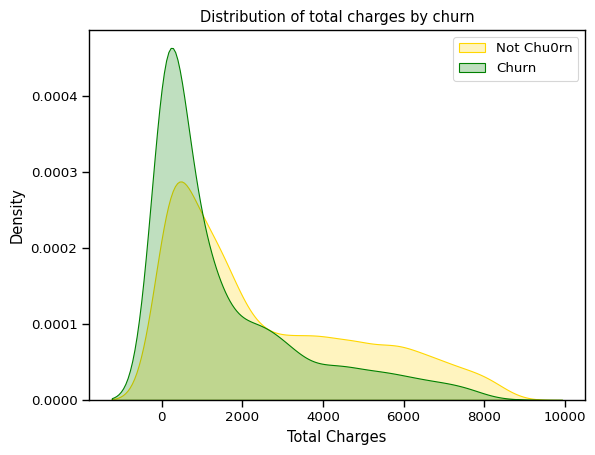

In [26]:
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'No') ],
                color="Gold", shade = True);
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Chu0rn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

In [27]:
fig = px.box(data, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

<h1>3. Modeling</h1>

In [28]:
data['Churn'] = data['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

In [30]:
# One-hot encoding
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
data = pd.get_dummies(data, columns=categorical_features, drop_first=True) 

In [31]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h2>3.1. Logistic regression</h2>

In [32]:
models = {}

# --- 3.1 Logistic Regression ---
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
param_dist_lr = {
    'lr__C': np.logspace(-3, 3, 100),  # Tham số C theo thang log
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
rand_lr = RandomizedSearchCV(pipe_lr, param_distributions=param_dist_lr,
                             n_iter=20, scoring='roc_auc', cv=5,
                             random_state=42, n_jobs=-1)
rand_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", rand_lr.best_params_)
models['Logistic Regression'] = rand_lr.best_estimator_

Best parameters for Logistic Regression: {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__C': 46.41588833612782}


<h2>3.2. Random Forest</h2>

In [33]:
# --- 3.2 Random Forest ---
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])
param_dist_rf = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}
rand_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf,
                             n_iter=20, scoring='roc_auc', cv=5,
                             random_state=42, n_jobs=-1)
rand_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", rand_rf.best_params_)
models['Random Forest'] = rand_rf.best_estimator_

Best parameters for Random Forest: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__max_depth': 5}


<h2>3.3. XGBoost</h2>

In [34]:
# --- 3.3 XGBoost ---
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'))
])
param_dist_xgb = {
    'xgb__n_estimators': [50, 100, 200, 300],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3]
}
rand_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb,
                              n_iter=20, scoring='roc_auc', cv=5,
                              random_state=42, n_jobs=-1)
rand_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", rand_xgb.best_params_)
models['XGBoost'] = rand_xgb.best_estimator_

Best parameters for XGBoost: {'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1}


<h2>3.4. Comparison </h2>


--- Logistic Regression ---
Accuracy: 0.733
AUC: 0.832
Confusion Matrix:
[[733 300]
 [ 75 299]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.73      0.75      1407


--- Random Forest ---
Accuracy: 0.741
AUC: 0.834
Confusion Matrix:
[[749 284]
 [ 80 294]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407


--- XGBoost ---
Accuracy: 0.770
AUC: 0.829
Confusion Matrix:
[[822 211]
 [113 261]]
Classification Report:
    

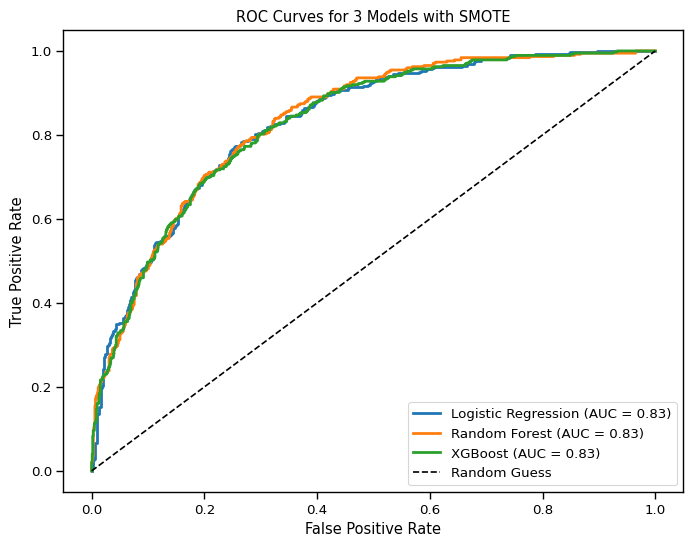

In [35]:
def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        y_prob = model.decision_function(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    
    print(f"\n--- {name} ---")
    print("Accuracy: {:.3f}".format(acc))
    print("AUC: {:.3f}".format(auc_val))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Vẽ ROC curve cho mô hình này
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_val:.2f})')
    
    evaluation_results.append({'Model': name, 'Accuracy': acc, 'AUC': auc_val})
evaluation_results = []
# Vẽ ROC curves cho cả 3 mô hình
plt.figure(figsize=(8,6))
for name, model in models.items():
    evaluate_model(model, name, X_test, y_test)
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 3 Models with SMOTE')
plt.legend(loc='lower right')
plt.show()


Tóm tắt kết quả đánh giá:
                 Model  Accuracy       AUC
0  Logistic Regression  0.733475  0.831898
1        Random Forest  0.741294  0.833843
2              XGBoost  0.769723  0.829005

Mô hình phù hợp nhất (dựa trên AUC):
Model       Random Forest
Accuracy         0.741294
AUC              0.833843
Name: 1, dtype: object


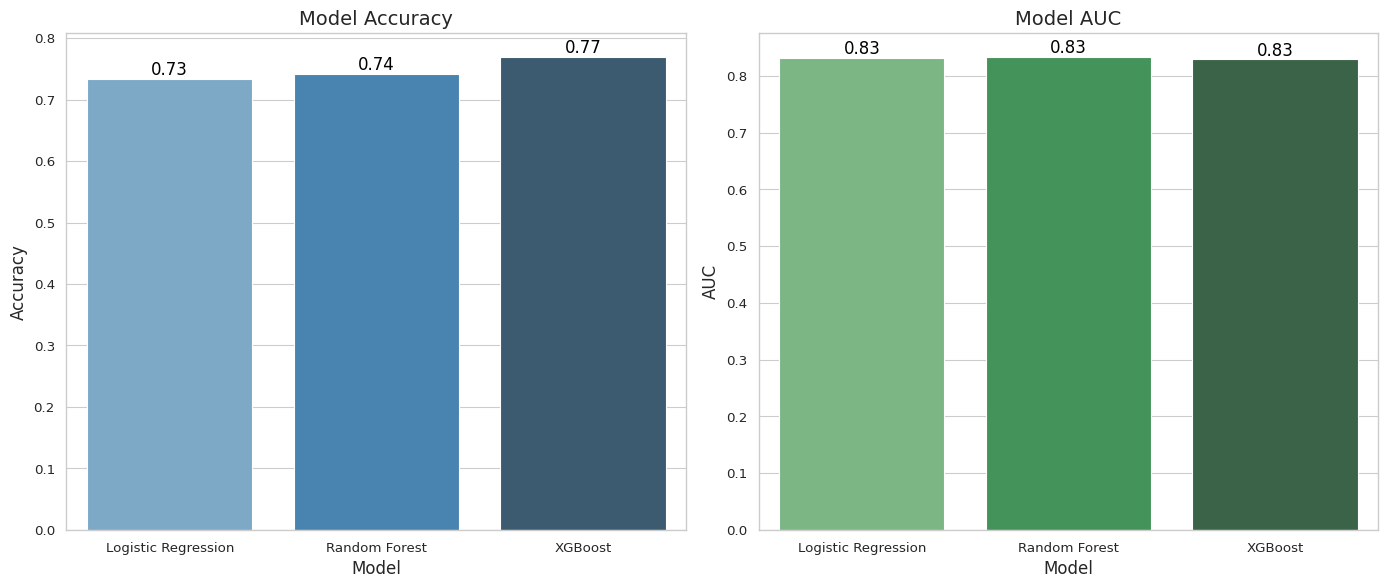

In [36]:
# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")

# ----------------------------
# 5. So sánh và hiển thị kết quả
# ----------------------------
# Tạo DataFrame chứa kết quả đánh giá
eval_df = pd.DataFrame(evaluation_results)
print("\nTóm tắt kết quả đánh giá:")
print(eval_df)

# Xác định mô hình có AUC cao nhất
best_model = eval_df.loc[eval_df['AUC'].idxmax()]
print("\nMô hình phù hợp nhất (dựa trên AUC):")
print(best_model)

# Vẽ biểu đồ so sánh Accuracy và AUC giữa các mô hình
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Biểu đồ Accuracy
sns.barplot(data=eval_df, x='Model', y='Accuracy', ax=ax[0], palette='Blues_d')
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_xlabel('Model', fontsize=12)
# Annotation cho Accuracy
for p in ax[0].patches:
    height = p.get_height()
    ax[0].annotate(f'{height:.2f}', 
                   (p.get_x() + p.get_width()/2., height),
                   ha='center', va='bottom', fontsize=12, color='black')

# Biểu đồ AUC
sns.barplot(data=eval_df, x='Model', y='AUC', ax=ax[1], palette='Greens_d')
ax[1].set_title('Model AUC', fontsize=14)
ax[1].set_ylabel('AUC', fontsize=12)
ax[1].set_xlabel('Model', fontsize=12)
# Annotation cho AUC
for p in ax[1].patches:
    height = p.get_height()
    ax[1].annotate(f'{height:.2f}', 
                   (p.get_x() + p.get_width()/2., height),
                   ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()


<h1>4. Feature Importance</h1>

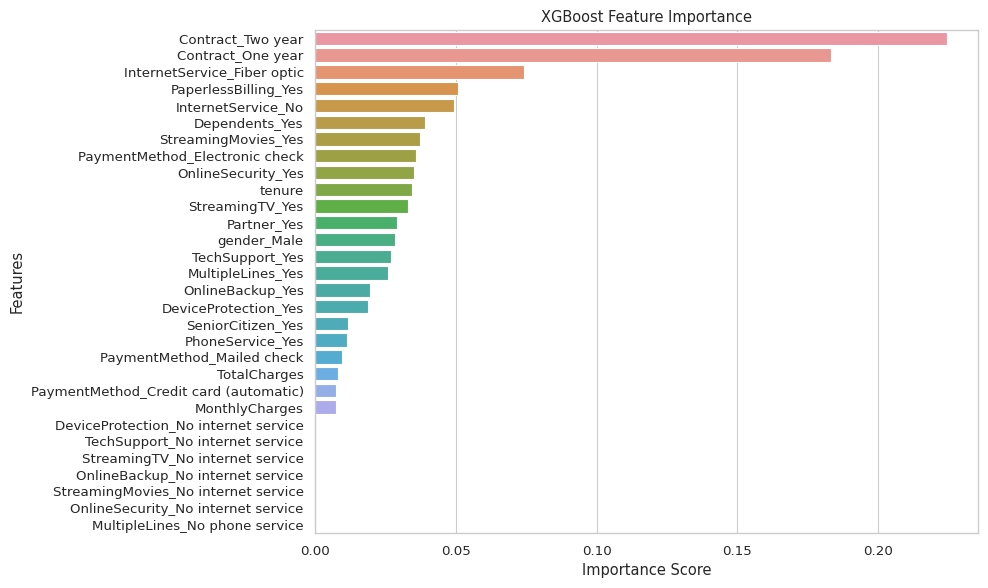

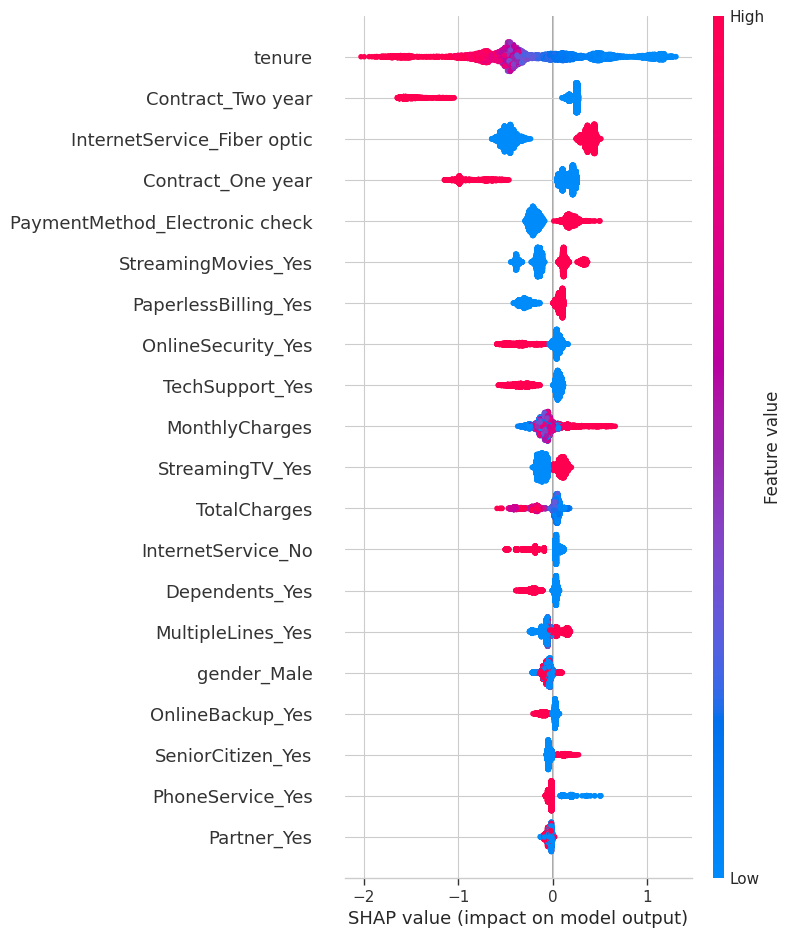

In [37]:
best_xgb = models['XGBoost']

xgb_model = best_xgb.named_steps['xgb']
scaler = best_xgb.named_steps['scaler']

X_train_scaled = scaler.transform(X_train)

# ----------------------------
# 1. Feature Importance từ XGBoost
# ----------------------------
importances = xgb_model.feature_importances_
# Sắp xếp theo thứ tự giảm dần
importance_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_series.values, y=importance_series.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# ----------------------------
# 2. Sử dụng SHAP để giải thích mô hình
# ----------------------------

# Tạo TreeExplainer cho XGBoost (làm việc với dữ liệu đã chuẩn hóa)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_scaled)

# Tạo DataFrame cho dữ liệu đã chuẩn hóa để hiển thị tên feature
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Vẽ SHAP Summary Plot
shap.summary_plot(shap_values, X_train_scaled_df)


Ở đây chúng ta có thể thấy 4 biến là tenure, Contract_Two year, InternetService_Fiber optic, Contract_One year là các biến có tầm ảnh hưởng quan trọng nhất đến target của chúng ta! Hãy cùng nhau phân tích 4 biến này nhé!


In [38]:
top_features = ['tenure','Contract_Two year', 'InternetService_Fiber optic', 'Contract_One year']
df_analysis = data[['Churn'] + top_features].copy()
df_analysis.head()

,Churn,tenure,Contract_Two year,InternetService_Fiber optic,Contract_One year
0,0,1,False,False,False
1,0,34,False,False,True
2,1,2,False,False,False
3,0,45,False,False,True
4,1,2,False,True,False


In [39]:
group_stats = df_analysis.groupby('Churn')[top_features].agg(['mean', 'median', 'count'])
group_stats

tenure              Contract_Two year               \
            mean median count              mean median count   
Churn                                                          
0      37.650010   38.0  5163          0.317064    0.0  5163   
1      17.979133   10.0  1869          0.025682    0.0  1869   

      InternetService_Fiber optic              Contract_One year               
                             mean median count              mean median count  
Churn                                                                          
0                        0.348441    0.0  5163          0.252954    0.0  5163  
1                        0.693954    1.0  1869          0.088818    0.0  1869

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

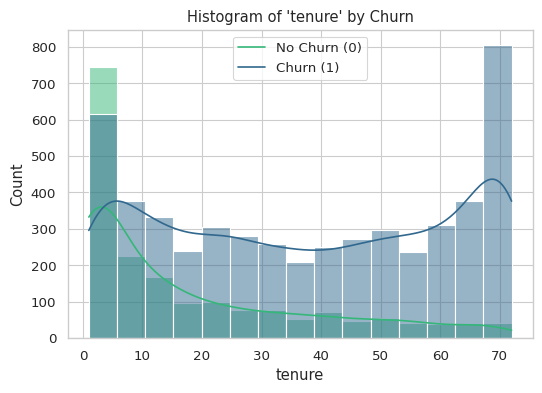

In [40]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df_analysis, x='tenure', hue='Churn', palette='viridis', kde=True)
plt.title("Histogram of 'tenure' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()

## 🔍 Phân tích

> **Phân tích dữ liệu cho thấy thời gian gắn bó (Tenure) là yếu tố then chốt trong việc dự báo Churn.**

- **📉 Tenure ngắn & Churn cao**
  - Khách hàng với **tenure ngắn** có xu hướng **rời bỏ dịch vụ (Churn)** với tỷ lệ cao.
  - Điều này cho thấy giai đoạn đầu sử dụng dịch vụ là thời điểm rủi ro lớn.

- **📈 Tenure dài & Giữ chân khách hàng**
  - Khách hàng có **tenure dài** thường có khả năng **giữ chân cao** và ít có khả năng rời bỏ dịch vụ.
  - Một khi vượt qua được giai đoạn ban đầu, khách hàng có xu hướng trở nên trung thành hơn.

- **⏰ Giai đoạn đầu quan trọng**
  - **Giai đoạn đầu** (tenure ngắn) là thời điểm quyết định để **áp dụng các chiến lược giữ chân khách hàng**.
  - Đầu tư vào trải nghiệm khách hàng, ưu đãi đặc biệt và hỗ trợ trong giai đoạn này có thể giảm thiểu rủi ro churn đáng kể.

---

### 👉 Lời khuyên chiến lược

- **Tập trung vào khách hàng mới:**  
  Xây dựng các chương trình chăm sóc và ưu đãi đặc biệt cho khách hàng ở giai đoạn đầu nhằm giúp họ vượt qua khoảng thời gian rủi ro.

- **Chương trình giữ chân:**  
  Phát triển các chiến lược dài hạn để tăng thời gian gắn bó của khách hàng, chẳng hạn như chương trình khách hàng thân thiết, giảm giá theo hợp đồng dài hạn, v.v.

- **Giám sát & can thiệp sớm:**  
  Theo dõi sát sao hành vi của khách hàng mới để có các biện pháp can thiệp sớm khi phát hiện dấu hiệu churn.



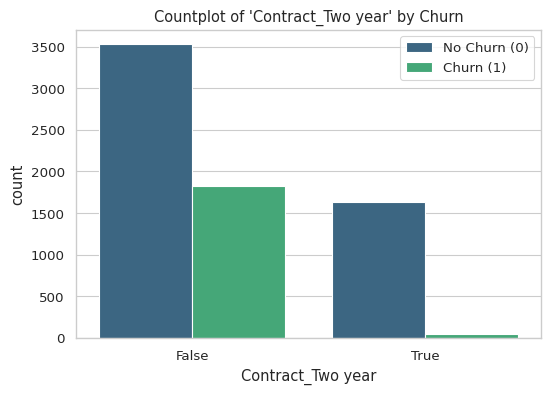

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='Contract_Two year', hue='Churn', palette='viridis')
plt.title("Countplot of 'Contract_Two year' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()

## 🔍 Phân tích

---
### 📉 Khách hàng không có hợp đồng hai năm & Churn cao

- **Khách hàng không có hợp đồng hai năm** (`Contract_Two year = False`) có xu hướng **rời bỏ dịch vụ (Churn)** với tỷ lệ cao hơn.
- Điều này cho thấy **sự linh hoạt ngắn hạn** có thể dẫn đến **ít gắn bó hơn** với dịch vụ.

---

### 📈 Hợp đồng hai năm & Giữ chân khách hàng

- **Khách hàng có hợp đồng hai năm** (`Contract_Two year = True`) thường có khả năng **giữ chân cao** và ít có khả năng rời bỏ dịch vụ.
- Cam kết dài hạn cho thấy sự **trung thành** và **hài lòng cao** với dịch vụ.

---

### ⏰ Cam kết hợp đồng quan trọng

- **Cam kết hợp đồng**, đặc biệt là hợp đồng hai năm, là yếu tố quyết định để **tăng cường giữ chân khách hàng** và **giảm thiểu churn**.

---

## 👉 Lời khuyên chiến lược

1. **Khuyến khích hợp đồng dài hạn:**
   - **Tạo ưu đãi và khuyến khích** cho khách hàng chọn hợp đồng hai năm để tăng cường cam kết và giảm churn.

2. **Chương trình giữ chân dựa trên hợp đồng:**
   - Phát triển các chương trình giữ chân đặc biệt cho khách hàng có hợp đồng dài hạn, chẳng hạn như **ưu đãi độc quyền** hoặc **dịch vụ nâng cao**.

3. **Tập trung vào giá trị dài hạn:**
   - **Truyền đạt giá trị của dịch vụ** trong dài hạn để khuyến khích khách hàng chọn các gói hợp đồng dài hạn.


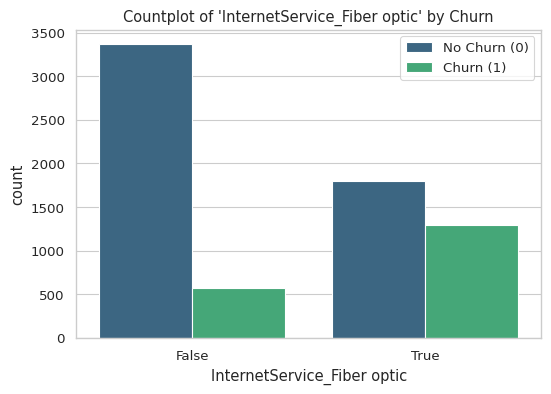

In [42]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='InternetService_Fiber optic', hue='Churn', palette='viridis')
plt.title("Countplot of 'InternetService_Fiber optic' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()


## 🔍 Phân tích

---

### 📉 Không dùng Fiber Optic & Churn thấp

- **Khách hàng không sử dụng dịch vụ cáp quang** (`InternetService_Fiber optic = False`) có xu hướng **churn thấp hơn**.
- Điều này cho thấy **dịch vụ Internet không phải cáp quang** có khả năng **giữ chân khách hàng tốt hơn**.

---

### 📈 Dùng Fiber Optic & Churn cao

- **Khách hàng sử dụng dịch vụ cáp quang** (`InternetService_Fiber optic = True`) có **tỷ lệ churn cao hơn** so với nhóm không sử dụng.
- Mặc dù cáp quang cung cấp tốc độ cao, nhưng nó có thể đi kèm với **vấn đề về chất lượng dịch vụ** hoặc **chi phí cao**, dẫn đến việc khách hàng dễ rời bỏ.

---

### ⏰ Dịch vụ Fiber Optic cần quan tâm

- **Dịch vụ cáp quang** là một yếu tố cần được xem xét kỹ lưỡng trong chiến lược giảm thiểu churn.
- **Cần tìm hiểu nguyên nhân** đằng sau tỷ lệ churn cao ở nhóm khách hàng sử dụng dịch vụ cáp quang.

---

## 👉 Lời khuyên chiến lược

1. **Tìm hiểu nguyên nhân churn cáp quang:**
   - Nghiên cứu kỹ lưỡng các lý do khách hàng sử dụng cáp quang rời bỏ dịch vụ.
   - Xem xét các yếu tố như **giá cả**, **chất lượng dịch vụ không ổn định**, **sự cạnh tranh** và **kỳ vọng của khách hàng**.

2. **Cải thiện trải nghiệm dịch vụ cáp quang:**
   - **Nâng cao chất lượng và độ ổn định** của dịch vụ.
   - Đảm bảo **giá cả cạnh tranh** và phù hợp với giá trị dịch vụ mang lại.
   - Cung cấp **hỗ trợ kỹ thuật chuyên nghiệp và nhanh chóng** cho khách hàng sử dụng dịch vụ cáp quang.

3. **Tập trung vào giữ chân khách hàng cáp quang:**
   - Phát triển các **chương trình chăm sóc khách hàng đặc biệt** cho nhóm khách hàng sử dụng cáp quang nhằm tăng sự hài lòng và lòng trung thành.
   - **Thu thập phản hồi thường xuyên** từ khách hàng để liên tục cải thiện dịch vụ và đáp ứng nhu cầu của họ.


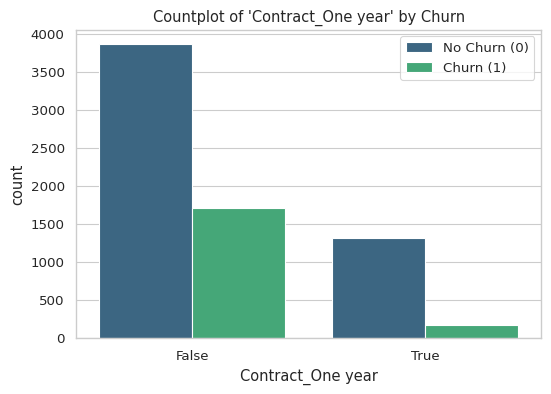

In [43]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='Contract_One year', hue='Churn', palette='viridis')
plt.title("Countplot of 'Contract_One year' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()

## 🔍 Phân tích
---

### 📉 Không hợp đồng một năm & Churn cao

- **Khách hàng không có hợp đồng một năm** (`Contract_One year = False`) có xu hướng **rời bỏ dịch vụ (Churn) với tỷ lệ cao hơn đáng kể**.
- Điều này cho thấy **sự thiếu cam kết hợp đồng** có thể dẫn đến **tỷ lệ churn cao**.

---

### 📈 Hợp đồng một năm & Giữ chân khách hàng

- **Khách hàng có hợp đồng một năm** (`Contract_One year = True`) có tỷ lệ **giữ chân cao** và **ít có khả năng rời bỏ dịch vụ**.
- Cam kết hợp đồng một năm thể hiện sự **gắn bó** và **giảm thiểu rủi ro churn**.

---

### ⏰ Hợp đồng một năm quan trọng

- **Hợp đồng một năm** đóng vai trò then chốt trong việc **giữ chân khách hàng** và **giảm tỷ lệ churn**.
- Khuyến khích khách hàng ký hợp đồng một năm có thể là **một chiến lược hiệu quả**.

---

## 👉 Lời khuyên chiến lược

1. **Khuyến khích hợp đồng một năm:**
   - Tạo động lực và ưu đãi để khách hàng lựa chọn hợp đồng một năm.
   - Ví dụ: **giảm giá**, **quà tặng** hoặc các **lợi ích độc quyền** khi ký hợp đồng dài hạn.

2. **Tận dụng hợp đồng một năm cho chương trình giữ chân:**
   - Xây dựng các chương trình chăm sóc và giữ chân khách hàng tập trung vào nhóm có hợp đồng một năm.
   - Áp dụng các chương trình như **khách hàng thân thiết** hoặc **ưu đãi gia hạn hợp đồng**.

3. **Truyền thông về lợi ích của hợp đồng:**
   - Nhấn mạnh các **lợi ích của việc ký hợp đồng một năm**, như **giá ổn định**, **dịch vụ liên tục** và **ưu đãi đặc biệt**.
   - Điều này giúp khuyến khích khách hàng chọn lựa hình thức hợp đồng một năm, tạo ra giá trị lâu dài.

---


<h1>5. Modeling With Features Importance</h1>

In [44]:
top_4_features = ['tenure','Contract_Two year', 'InternetService_Fiber optic', 'Contract_One year']

X_train_top4 = X_train[top_4_features]
X_test_top4 = X_test[top_4_features]

pipe_xgb_top4 = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'))
])

# Sử dụng cùng param_dist_xgb đã định nghĩa trước đó
rand_xgb_top4 = RandomizedSearchCV(pipe_xgb_top4, param_distributions=param_dist_xgb,
                                   n_iter=20, scoring='roc_auc', cv=5,
                                   random_state=42, n_jobs=-1)
rand_xgb_top4.fit(X_train_top4, y_train)
print("Best parameters for XGBoost (Top 4 Features):", rand_xgb_top4.best_params_)

# Lưu mô hình huấn luyện với 3 biến vào dictionary
models['XGBoost_top4'] = rand_xgb_top4.best_estimator_


Best parameters for XGBoost (Top 4 Features): {'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01}



--- XGBoost Full ---
Accuracy: 0.770
AUC: 0.829
Confusion Matrix:
[[822 211]
 [113 261]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1033
           1       0.55      0.70      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.79      0.77      0.78      1407


--- XGBoost Top 4 ---
Accuracy: 0.721
AUC: 0.818
Confusion Matrix:
[[727 306]
 [ 86 288]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1033
           1       0.48      0.77      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



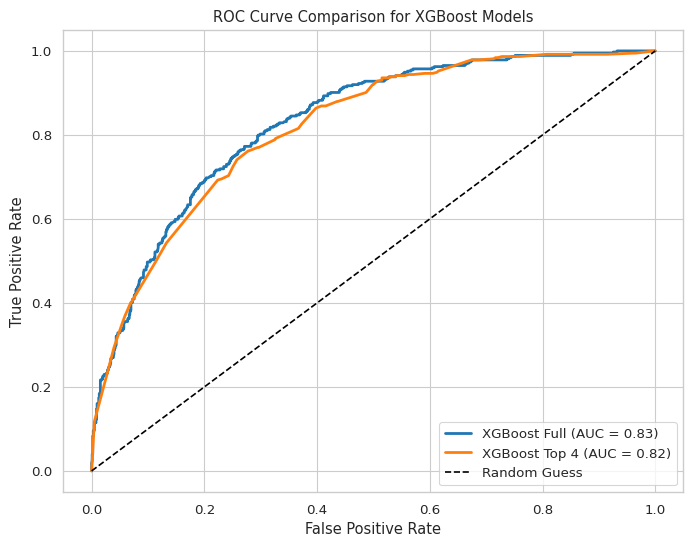

In [45]:
plt.figure(figsize=(8,6))
evaluate_model(models['XGBoost'], "XGBoost Full", X_test, y_test)

evaluate_model(models['XGBoost_top4'], "XGBoost Top 4", X_test[top_4_features], y_test)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for XGBoost Models')
plt.legend(loc='lower right')
plt.show()